## Import Data and required packages

In [1]:
import json
import pandas as pd
from collections import Counter
import os
import glob
import cv2
from tqdm import tqdm
import shutil
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from PIL import Image
from shutil import copy2
from torchvision import transforms, datasets
import random
from PIL import Image, ImageEnhance

### Loading the metadata

In [2]:

def load_photo_metadata(json_path):
    data = []
    with open(json_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

photo_df = load_photo_metadata('photos.json')

In [3]:
photo_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [4]:
photo_df['label'].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [5]:
photo_df['label'].value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [6]:
photo_df.isnull().sum()

photo_id       0
business_id    0
caption        0
label          0
dtype: int64

In [7]:
photo_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


## Find the frequency of images under each labels

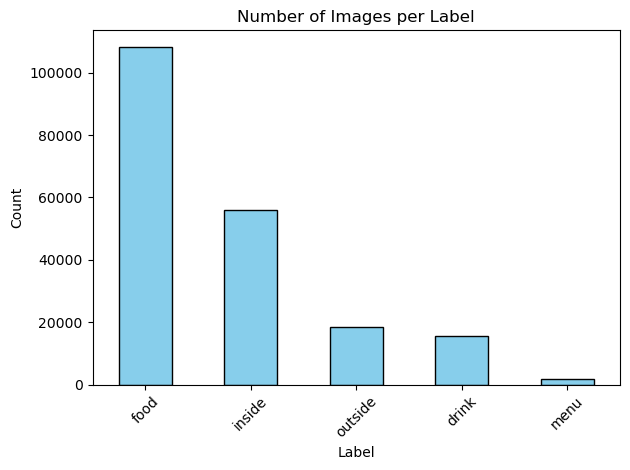

In [8]:
# Count number of images per label
label_counts = photo_df['label'].value_counts()

# Optional: Visualize the distribution using a bar chart
import matplotlib.pyplot as plt

label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Images per Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Samplling the Data

#### As we are have huge data , which our system cant handel we are sampling the data 

In [9]:
# 1. Load and sample metadata
def load_and_sample_metadata(df, sample_counts):

    sampled_df = pd.concat([df[df['label'] == label].sample(n=count, random_state=42) for label, count in sample_counts.items()])

    return sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [10]:

# 2. Helper function for copying one image
def copy_single_image(photo_id, src_dir, dst_dir):
    matches = glob.glob(os.path.join(src_dir, f"{photo_id}.*"))
    if not matches:
        return False  # skipped

    src_path = matches[0]
    dst_path = os.path.join(dst_dir, f"{photo_id}.jpg")
    try:
        shutil.copyfile(src_path, dst_path)
        return True  # copied
    except Exception:
        return False  # failed to copy

In [11]:

# 3. Parallel copy function
def copy_sampled_images_parallel(photo_df, src_dir, dst_dir, max_workers=8):
    os.makedirs(dst_dir, exist_ok=True)

    photo_ids = photo_df['photo_id'].tolist()
    total = len(photo_ids)

    copied = 0
    skipped = 0

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(copy_single_image, pid, src_dir, dst_dir): pid
            for pid in photo_ids
        }

        for future in tqdm(as_completed(futures), total=total):
            result = future.result()
            if result:
                copied += 1
            else:
                skipped += 1

    print(f"\n Copied {copied} images to '{dst_dir}'")
    print(f" Skipped {skipped} images (missing or unreadable)")


In [12]:
# === Block 1 Execution with parallel copy ===
sample_counts = {
    'food': 5000,
    'inside': 5000,
    'outside': 5000,
    'drink': 5000,
    'menu': 1500
}

## Sample the data only once , for next time /  restarting the kernal / comment the below code block and use reconstructing code to save time

In [ ]:
#photo_df = load_and_sample_metadata(photo_df, sample_counts)
#copy_sampled_images_parallel(photo_df, src_dir="photos", dst_dir="sampled_photos", max_workers=18)

### reconstructing metadata of sampled_photos instead trying to copying every time we restart kernal. 

In [14]:
# Load full original metadata again
full_df = load_photo_metadata("photos.json")

# Get photo_ids from the sampled_photos folder
sampled_dir = "sampled_photos"
sampled_files = glob.glob(os.path.join(sampled_dir, "*.*"))

# Check if directory has any image files
if not sampled_files:
    print("[INFO] No photos found in 'sampled_photos' directory.")
else:
    print(f"[INFO] Found {len(sampled_files)} photo files in 'sampled_photos'.")

    # Extract photo_id from filenames (e.g., "abc123.jpg" → "abc123")
    sampled_photo_ids = [os.path.splitext(os.path.basename(f))[0] for f in sampled_files]

    # Filter the full metadata for these photo_ids
    photo_df = full_df[full_df['photo_id'].isin(sampled_photo_ids)].reset_index(drop=True)

    if photo_df.empty:
        print("[INFO] No matching records found in metadata.")
    else:
        # Save reconstructed metadata
        photo_df.to_csv("photo_df.csv", index=False)
        print(f"[INFO] Sampled metadata saved with {len(photo_df)} records to 'sampled_metadata.csv'.")


[INFO] Found 21500 photo files in 'sampled_photos'.
[INFO] Sampled metadata saved with 21500 records to 'sampled_metadata.csv'.


## Now that we got sampled data , lets explore the quality of the images and size disturbution of our data 

In [15]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def plot_file_size_distribution(image_dir):
    file_info = []

    for fname in os.listdir(image_dir):
        path = os.path.join(image_dir, fname)
        if os.path.isfile(path):
            size_kb = os.path.getsize(path) / 1024  # KB
            file_info.append((fname, size_kb))

    if not file_info:
        print("[INFO] No files found in directory.")
        return

    # Sort by file size
    file_info.sort(key=lambda x: x[1])
    file_sizes_kb = [size for _, size in file_info]

    # Plot histogram
    plt.hist(file_sizes_kb, bins=50, edgecolor='black')
    plt.title("Distribution of Image File Sizes")
    plt.xlabel("File Size (KB)")
    plt.ylabel("Number of Files")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute stats
    avg_size = sum(file_sizes_kb) / len(file_sizes_kb)
    print(f"[INFO] Analyzed {len(file_sizes_kb)} image files.")
    print(f"[INFO] Avg size: {avg_size:.2f} KB")
    print(f"[INFO] Min size: {file_sizes_kb[0]:.2f} KB")
    print(f"[INFO] Max size: {file_sizes_kb[-1]:.2f} KB")


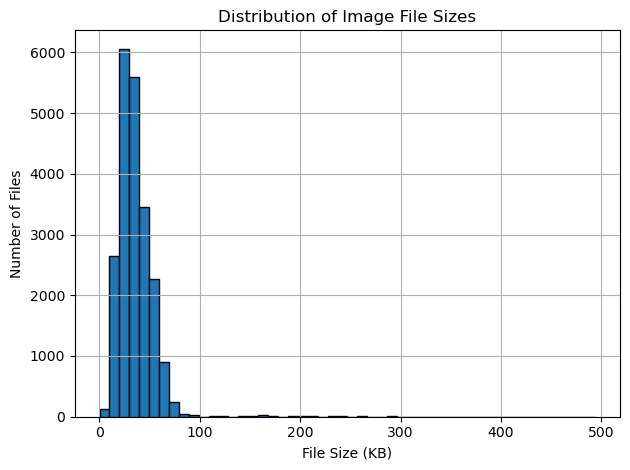

[INFO] Analyzed 21500 image files.
[INFO] Avg size: 35.89 KB
[INFO] Min size: 0.24 KB
[INFO] Max size: 493.83 KB


In [21]:
# Example usage
plot_file_size_distribution("sampled_photos")

### allmost all images are less than 100 kb , most of them are between 30 to 50 kb sizes , which suggest that theses photo are already compressed, very few are greater than 200 and 500 , which might have not been compressed

### Now lets see the distuburtion of pixel sizes 

In [22]:

def plot_pixel_size_distribution(image_dir):
    widths = []
    heights = []

    for fname in os.listdir(image_dir):
        path = os.path.join(image_dir, fname)
        if os.path.isfile(path):
            try:
                with Image.open(path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception as e:
                print(f"[WARN] Skipping unreadable image: {fname} — {e}")

    if not widths:
        print("[INFO] No readable images found in directory.")
        return

    # Plot Width Distribution
    plt.hist(widths, bins=40, edgecolor='black')
    plt.title("Image Width Distribution")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Number of Images")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Height Distribution
    plt.hist(heights, bins=40, edgecolor='black')
    plt.title("Image Height Distribution")
    plt.xlabel("Height (pixels)")
    plt.ylabel("Number of Images")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"[INFO] Total images analyzed: {len(widths)}")
    print(f"[INFO] Most common resolution: {max(set(zip(widths, heights)), key=lambda x: (widths.count(x[0]), heights.count(x[1])))}")



[WARN] Skipping unreadable image: 1wd_eyhMrTqUmicDmn4_Kw.jpg — cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\1wd_eyhMrTqUmicDmn4_Kw.jpg'
[WARN] Skipping unreadable image: 2S78q98b_VpBD7vkrDE5-A.jpg — cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\2S78q98b_VpBD7vkrDE5-A.jpg'
[WARN] Skipping unreadable image: 43fHlHSYQ_79OBJW1aVUxA.jpg — cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\43fHlHSYQ_79OBJW1aVUxA.jpg'
[WARN] Skipping unreadable image: 9BvYOtforBBP6MvvDogtmw.jpg — cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\9BvYOtforBBP6MvvDogtmw.jpg'
[WARN] Skipping unreadable image: AMSyCOP3-Eb_ivNA8w1Vhw

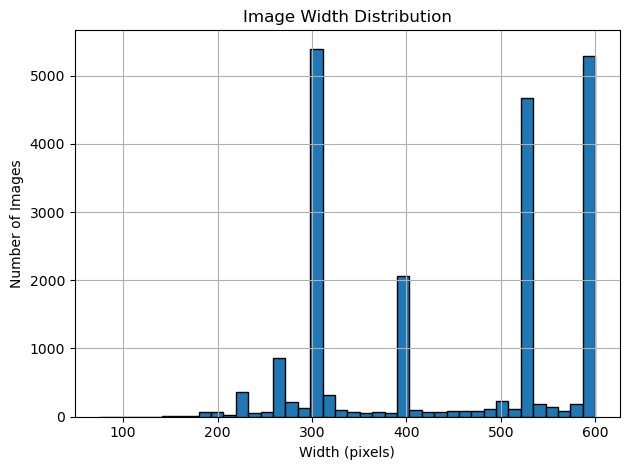

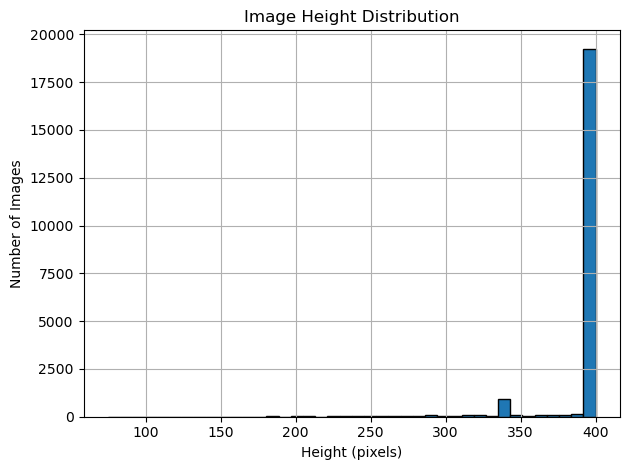

[INFO] Total images analyzed: 21487
[INFO] Most common resolution: (300, 400)


In [23]:
plot_pixel_size_distribution("sampled_photos")


### for width disturbution , there are clearl spikes at 300,400,600 px. this indicates 3 to 4 standard resolutions , might be of based of phone , third part apps like snap or cameras .
### for height disturbution , nearly all of them are 400 px , must be most of them are portrait 

## Resize and normalize the images

In [16]:
# === Configuration ===
SOURCE_DIR = "sampled_photos"
DEST_DIR = "resized_photos"
TARGET_SIZE = (128, 128)
MAX_WORKERS = 16  # Adjust based on your system

# === Ensure destination exists ===
os.makedirs(DEST_DIR, exist_ok=True)

# === Get all image files ===
files = glob.glob(os.path.join(SOURCE_DIR, "*.*"))

if not files:
    print("[INFO] No files found in 'sampled_photos/'. Please check your directory.")
else:
    print(f"[INFO] Found {len(files)} files. Starting processing...")

    def process_image(src_path):
        try:
            photo_id = os.path.splitext(os.path.basename(src_path))[0]
            img = Image.open(src_path).convert("RGB")
            img = img.resize(TARGET_SIZE)
            img_arr = np.array(img).astype(np.float32) / 255.0
            img = Image.fromarray((img_arr * 255).astype(np.uint8))
            dst_path = os.path.join(DEST_DIR, f"{photo_id}.jpg")
            img.save(dst_path)
            return True
        except Exception as e:
            print(f"[WARN] Failed to process {src_path}: {e}")
            return False

    # === Use threading with progress bar ===
    results = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(process_image, f): f for f in files}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing images"):
            results.append(future.result())

    print(f"[DONE] Successfully processed {sum(results)} of {len(files)} images.")

[INFO] Found 21500 files. Starting processing...


Processing images:   6%|▌         | 1232/21500 [00:03<01:01, 331.30it/s]

[WARN] Failed to process sampled_photos\1wd_eyhMrTqUmicDmn4_Kw.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\1wd_eyhMrTqUmicDmn4_Kw.jpg'


Processing images:   6%|▌         | 1333/21500 [00:03<01:02, 321.37it/s]

[WARN] Failed to process sampled_photos\2S78q98b_VpBD7vkrDE5-A.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\2S78q98b_VpBD7vkrDE5-A.jpg'


Processing images:   8%|▊         | 1796/21500 [00:05<00:54, 360.45it/s]

[WARN] Failed to process sampled_photos\43fHlHSYQ_79OBJW1aVUxA.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\43fHlHSYQ_79OBJW1aVUxA.jpg'


Processing images:  16%|█▋        | 3525/21500 [00:10<01:03, 281.79it/s]

[WARN] Failed to process sampled_photos\9BvYOtforBBP6MvvDogtmw.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\9BvYOtforBBP6MvvDogtmw.jpg'


Processing images:  19%|█▉        | 4180/21500 [00:12<00:56, 305.62it/s]

[WARN] Failed to process sampled_photos\AMSyCOP3-Eb_ivNA8w1Vhw.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\AMSyCOP3-Eb_ivNA8w1Vhw.jpg'


Processing images:  20%|█▉        | 4243/21500 [00:12<00:57, 301.79it/s]

[WARN] Failed to process sampled_photos\ARwqGQZaT0p-XpYYjMXgQg.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\ARwqGQZaT0p-XpYYjMXgQg.jpg'


Processing images:  50%|████▉     | 10702/21500 [00:33<00:30, 354.23it/s]

[WARN] Failed to process sampled_photos\kjMBhxBXOUE7SSUQb-YQbw.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\kjMBhxBXOUE7SSUQb-YQbw.jpg'


Processing images:  55%|█████▍    | 11802/21500 [00:36<00:27, 351.56it/s]

[WARN] Failed to process sampled_photos\l_rMdwgrvjm2PyHyXBcBTw.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\l_rMdwgrvjm2PyHyXBcBTw.jpg'


Processing images:  59%|█████▉    | 12673/21500 [00:38<00:25, 349.71it/s]

[WARN] Failed to process sampled_photos\NfayhoTudVJQsEF-XlPyjw.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\NfayhoTudVJQsEF-XlPyjw.jpg'


Processing images:  63%|██████▎   | 13444/21500 [00:40<00:23, 349.28it/s]

[WARN] Failed to process sampled_photos\OK6HsALzFcBAUlrroKHZGg.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\OK6HsALzFcBAUlrroKHZGg.jpg'


Processing images:  69%|██████▊   | 14728/21500 [00:45<00:22, 301.63it/s]

[WARN] Failed to process sampled_photos\QhATx1B1n8uf8C6siMNTfA.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\QhATx1B1n8uf8C6siMNTfA.jpg'


Processing images:  72%|███████▏  | 15421/21500 [00:47<00:21, 287.27it/s]

[WARN] Failed to process sampled_photos\RhC7TNmFvbR9GWrlrl5dsA.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\RhC7TNmFvbR9GWrlrl5dsA.jpg'


Processing images:  79%|███████▉  | 17039/21500 [00:52<00:12, 364.27it/s]

[WARN] Failed to process sampled_photos\tSHz7RzlgceAItRejZ396A.jpg: cannot identify image file 'C:\\Users\\amrut\\OneDrive\\Desktop\\ComputerVisionAssignments\\Assignment1\\New folder\\New folder\\sampled_photos\\tSHz7RzlgceAItRejZ396A.jpg'


Processing images: 100%|██████████| 21500/21500 [01:02<00:00, 341.36it/s]

[DONE] Successfully processed 21487 of 21500 images.


In [18]:
photo_df.head()

,photo_id,business_id,caption,label
0,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
1,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
2,3ROd5PAQ_0OkmoKWVO06ag,u9vhzYtXpfyvAOAMnyy-Cw,Inside reception,inside
3,RBBVVDG3t4lTTyl_vW2W3A,KRc2irAIY3pgGlV0p4znmQ,,inside
4,6LJa8QZOGBjt9maE5miLhw,368cyArdo0P0aDUOhhE4PA,Drive-thru menu,menu


## Split data into Train, Test, and Validation.

In [31]:
#Train + temp split
train_df, temp_df = train_test_split(photo_df,test_size=0.20,random_state=42)

# Validation + Test split from temp
val_df, test_df = train_test_split(temp_df,test_size=0.5,random_state=42)

# Sanity checks
print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Save split metadata to CSVs
train_df.to_csv("train_metadata.csv", index=False)
val_df.to_csv("val_metadata.csv", index=False)
test_df.to_csv("test_metadata.csv", index=False)

print("\n✅ Data split into train/val/test and saved as CSVs.")


Train set: 17200 images
Validation set: 2150 images
Test set: 2150 images

✅ Data split into train/val/test and saved as CSVs.


In [ ]:
import os
import pandas as pd
from shutil import copy2

# Paths
RESIZED_DIR = "resized_photos"
SPLIT_DIR = "split_photos"

# Read split metadata
splits = {
    'train': pd.read_csv("train_metadata.csv"),
    'val': pd.read_csv("val_metadata.csv"),
    'test': pd.read_csv("test_metadata.csv")
}

# Copy files into flat train/val/test folders
for split_name, df in splits.items():
    split_folder = os.path.join(SPLIT_DIR, split_name)
    os.makedirs(split_folder, exist_ok=True)

    for _, row in df.iterrows():
        photo_id = str(row['photo_id'])
        src_path = os.path.join(RESIZED_DIR, f"{photo_id}.jpg")
        dst_path = os.path.join(split_folder, f"{photo_id}.jpg")

        if os.path.exists(src_path):
            copy2(src_path, dst_path)

print("\n Images organized into train/val/test folders.")



 Images organized into flat train/val/test folders.


## Data Augmentation 

In [19]:
# === Configuration ===
TRAIN_DIR = "split_photos/train"
AUG_DIR = "augmented_photos/train"
METADATA_PATH = "train_metadata.csv"
AUG_METADATA_PATH = "train_augmented_metadata.csv"
TARGET_SIZE = (128, 128)

In [20]:
# === Ensure output folder exists ===
os.makedirs(AUG_DIR, exist_ok=True)

# === Load original metadata if available ===
original_metadata = pd.read_csv(METADATA_PATH) if os.path.exists(METADATA_PATH) else None

# === Augmentation Function ===
def apply_augmentations(img):
    # Random crop + resize
    w, h = img.size
    scale = random.uniform(0.8, 1.0)
    new_w, new_h = int(w * scale), int(h * scale)
    left = random.randint(0, w - new_w)
    top = random.randint(0, h - new_h)
    img = img.crop((left, top, left + new_w, top + new_h)).resize(TARGET_SIZE)

    # Random horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Color jitter
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2))
    img = ImageEnhance.Color(img).enhance(random.uniform(0.8, 1.2))

    return img

In [21]:
# Parallel processing function
def augment_and_save(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        aug_img = apply_augmentations(img)

        base = os.path.splitext(os.path.basename(img_path))[0]
        aug_name = f"{base}_aug.jpg"
        aug_path = os.path.join(AUG_DIR, aug_name)
        aug_img.save(aug_path)

        label = "unknown"
        if original_metadata is not None and base in original_metadata['photo_id'].values:
            record = original_metadata[original_metadata['photo_id'] == base].iloc[0].to_dict()
            label = record.get("label", "unknown")
            record["photo_id"] = base + "_aug"
            record["label"] = label
            return record
        else:
            return {"photo_id": base + "_aug", "label": label}
    except Exception as e:
        return None


In [22]:
# === Collect image paths ===
image_paths = glob.glob(os.path.join(TRAIN_DIR, "*.*"))
augmented_records = []

print(f"[INFO] Starting parallel augmentation for {len(image_paths)} images...")

# === Run with tqdm progress bar ===
with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(augment_and_save, path) for path in image_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Augmenting"):
        result = future.result()
        if result:
            augmented_records.append(result)

# === Save metadata ===
aug_df = pd.DataFrame(augmented_records)
aug_df.to_csv(AUG_METADATA_PATH, index=False)

print(f"[DONE] Augmented {len(aug_df)} images. Saved to '{AUG_DIR}' and metadata to '{AUG_METADATA_PATH}'.")

[INFO] Starting parallel augmentation for 17192 images...


Augmenting: 100%|██████████| 17192/17192 [01:39<00:00, 173.29it/s]

[DONE] Augmented 17192 images. Saved to 'augmented_photos/train' and metadata to 'train_augmented_metadata.csv'.


## Now lets Do Advanced Preprocessing (Intensity thresholding, Histogram equalization and  Gaussian blur)

In [ ]:
#  input/output paths
AUG_INPUT_DIR = "augmented_photos/train"
ADV_OUTPUT_DIR = "advanced_preprocessed/augmented_train"
os.makedirs(ADV_OUTPUT_DIR, exist_ok=True)

In [26]:
# === Advanced preprocessing function ===
def advanced_preprocess_image(image_path):
    # Load as grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Histogram Equalization
    equalized = cv2.equalizeHist(blurred)

    # Intensity Thresholding (binary mask)
    _, thresholded = cv2.threshold(equalized, 128, 255, cv2.THRESH_BINARY)

    return thresholded

In [27]:
# Collect image paths
image_paths = glob.glob(os.path.join(AUG_INPUT_DIR, "*.*"))

# Processing function
def process_and_save(image_path):
    try:
        processed = advanced_preprocess_image(image_path)
        filename = os.path.basename(image_path)
        save_path = os.path.join(ADV_OUTPUT_DIR, filename)
        cv2.imwrite(save_path, processed)
        return True
    except Exception as e:
        print(f"[WARN] Failed to process {image_path}: {e}")
        return False

In [28]:
# Run with ThreadPoolExecutor and tqdm
success_count = 0
with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(process_and_save, path) for path in image_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
        if future.result():
            success_count += 1

success_count, ADV_OUTPUT_DIR

Processing Images: 100%|██████████| 17192/17192 [00:37<00:00, 464.33it/s]


(17192, 'advanced_preprocessed/augmented_train')

## Display sample image before and after pre-processing

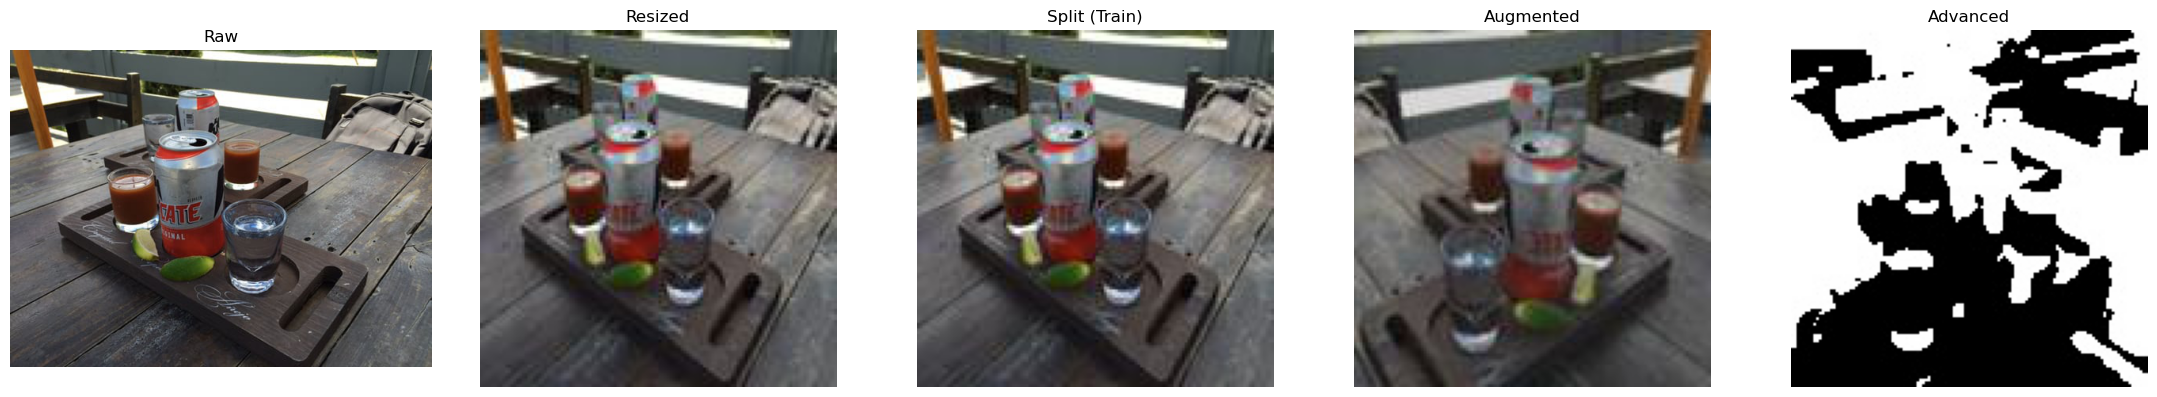

In [36]:
# Add path to raw photo (original before resize)
RAW_DIR = "photos"
raw_paths = glob.glob(os.path.join(RAW_DIR, "*.*"))

# Randomly select from split_photos/train and extract its basename
split_train_images = glob.glob(os.path.join("split_photos/train", "*.*"))
if split_train_images:
    random_image_path = random.choice(split_train_images)
    example_name = os.path.basename(random_image_path)

    # Build paths to the image at each stage
    paths = {
        "Raw": os.path.join(RAW_DIR, example_name),
        "Resized": os.path.join("resized_photos", example_name),
        "Split (Train)": os.path.join("split_photos/train", example_name),
        "Augmented": os.path.join("augmented_photos/train", example_name.replace(".jpg", "_aug.jpg")),
        "Advanced": os.path.join("advanced_preprocessed/augmented_train", example_name.replace(".jpg", "_aug.jpg"))
    }

    # Load and display each image
    fig, axes = plt.subplots(1, 5, figsize=(22, 4))
    for ax, (stage, path) in zip(axes, paths.items()):
        if os.path.exists(path):
            img = Image.open(path)
            ax.imshow(img if img.mode == "RGB" else img.convert("RGB"))
            ax.set_title(stage)
        else:
            ax.set_title(f"{stage}\n(Not Found)")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("[ERROR] No images found in split_photos/train/")

### Below is the Folder Structure for your understanding and operations performed on images in those folder

In [ ]:
#your_project/
#│
#├── raw_photos/
#│ └── Original unprocessed images
#│
#├── resized_photos/
#│ └── Resized to 128×128
#│ └── Pixel values scaled to [0, 1] (Normalization)
#│
#├── split_photos/
#│ ├── train/
#│ ├── val/
#│ ├── test/
#│ └── *.csv — metadata for each split
#│
#├── augmented_photos/
#│ └── train/
#│ └── Images augmented via:
#│ - Random crop
#│ - Horizontal flip
#│ - Color jitter (brightness, contrast, saturation)
#│ └── train_augmented_metadata.csv
#│
#├── advanced_preprocessed/
#│ └── augmented_train/
#│ └── Grayscale images processed with:
#│ - Gaussian Blur (noise reduction)
#│ - Histogram Equalization (contrast enhancement)
#│ - Intensity Thresholding (binary mask)
#│
#├── metadata/
#│ ├── train.csv
#│ ├── val.csv
#│ ├── test.csv

# Steps performed in pre-processing 
### Resizing and normalization is done for all images 
        ### data frame - photo_df.csv
### Train - test - val split 
        ### train_metadata.csv
        ### val_metadata.csv
        ### test_metadata.csv

## Note Augmentation and Advance pre-processing is applied only on train data to aviod Data Leakge 

### Augmented only training set (flip, crop, color jitter)
        ### train_augmented_metadata.csv
        ### val_metadata.csv
        ### test_metadata.csv
### Advanced preprocessing (grayscale + blur + hist eq + threshold)
        ### train_augmented_metadata.csv
        ### val_metadata.csv
        ### test_metadata.csv